In [2]:
## Setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


Loading vector data
Loading image data
Preprocessing data
Input shape:  (9400, 9)


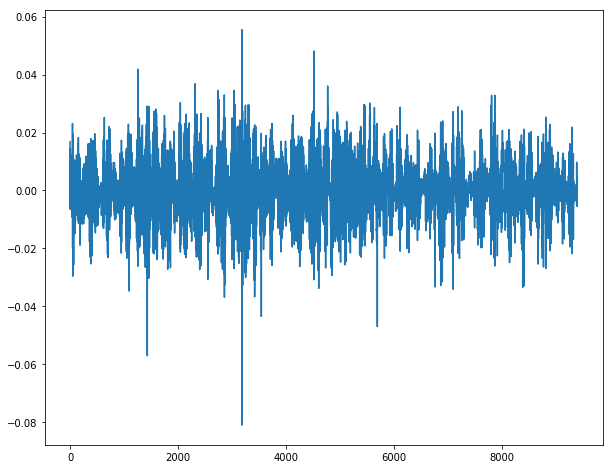

In [3]:
TRAIN_RATIO = 0.6

import utilities
# Datafile options:
x_data,img_data,y_data = utilities.load_data('flows_lowres_16k.npy')
#imu_data,flows_data,y_norm = utilities.load_data('../gbucket/center_cropped_300x300.npy')
#imu_data,x_data,y_norm = utilities.load_data('../gbucket/center_cropped_192x192.npy')

# Split into training/val data:
N_training = int(TRAIN_RATIO*x_data.shape[0])
N_validation = x_data.shape[0]- N_training

x_train = x_data[0:N_training,...]
img_train = img_data[0:N_training,...]
y_train = y_data[0:N_training]


img_val = img_data[N_training:,...]
x_val = x_data[N_training:,...]
y_val = y_data[N_training:]

print('Input shape: ', x_data.shape)

# Plot the discretization with perfect classification:
plt.plot(y_data)



In [4]:
R_HISTORY = 8
BATCH_SIZE = 128
IMG_BATCH_SIZE = 64
N_HIDDEN = 1024

tf.reset_default_graph() # remove all existing variables in the graph 
sess = get_session() # start a new Session

# Load the convolutional side of the network:
from classifiers.squeezenet import SqueezeNet
conv_model = SqueezeNet(128, 2, img_data.shape[1])
convsaver = tf.train.Saver()
convsaver.restore(sess, './checkpoints/classification_m39990')

# Load the recursive side of the network:
from classifiers.recursivenet import RecursiveNet
with tf.variable_scope('recursive_model'):
    model = RecursiveNet(BATCH_SIZE, R_HISTORY, N_HIDDEN)
        # Activations from the conv side:
    feats = conv_model.extract_features(conv_model.image, reuse=False)

# Slow way to initialize variables that is robust to partially loaded models:
uninitialized_vars = []
for var in tf.global_variables():
    try:
        sess.run(var)
    except tf.errors.FailedPreconditionError:
        uninitialized_vars.append(var)

        
init = tf.variables_initializer(uninitialized_vars)
sess.run(init)
saver = tf.train.Saver();


INFO:tensorflow:Restoring parameters from ./checkpoints/good_run


INFO:tensorflow:Restoring parameters from ./checkpoints/good_run


0 0.78375
Step:  0  Train:  0.78375  Val:  20.3701 LR:  0.099


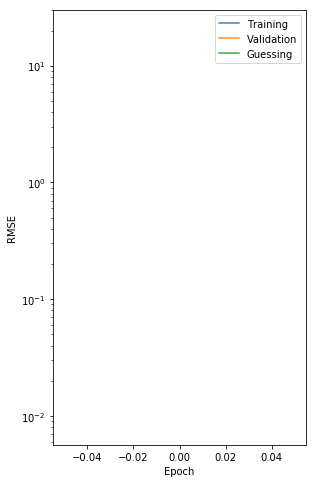

1 20.4678
2 4.04039
3 6.13612
4 3.26592
5 0.317127
6 1.85897
7 2.08191
8 1.31358
9 0.0114305
10 0.161373
11 0.256892
12 0.0582735
13 0.169738
14 0.130514
15 0.0260557
16 0.218641
17 0.102327
18 0.510801
19 0.281884
20 0.137301
21 0.175242
22 0.0575757
23 0.0342235
24 0.175037
25 0.439919
26 0.167126
27 0.114079
28 0.190596
29 0.206688
30 0.0485369
31 0.201821
32 0.178995
33 0.415031
34 0.234948
35 0.181665
36 0.192567
37 0.0549313
38 0.157735
39 0.234121
40 0.190407
41 0.0636991
42 0.186893
43 0.287483
44 0.235234
45 0.124741
46 0.0641341
47 0.148318
48 0.143606
49 0.0449574
50 0.137666
51 0.181088
52 0.155901
53 0.0416196
54 0.147312
55 0.203869
56 0.201077
57 0.132853
58 0.0555807
59 0.130724
60 0.204737
61 0.209075
62 0.146039
63 0.0391286
64 0.112144
65 0.171919
66 0.183138
67 0.166551
68 0.0957374
69 0.0108054
70 0.0593312
71 0.0530919
72 0.0110588
73 0.0891405
74 0.118531
75 0.0961585
76 0.0678796
77 0.0209602
78 0.0381298
79 0.00731167
80 0.0258903
81 0.026154
82 0.0108518
83 0.

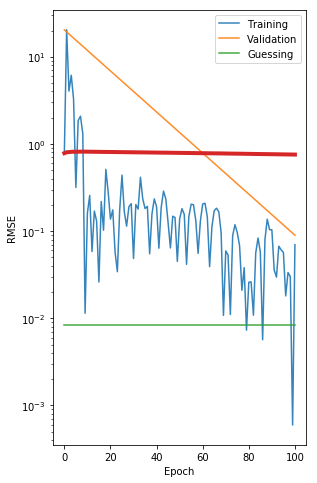

101 0.0904133
102 0.0887525
103 0.0393418
104 0.0132742
105 0.0433199
106 0.0327413
107 0.00373328
108 0.0168638
109 0.0177392
110 0.0407927
111 0.0398335
112 0.0185748
113 0.00357775
114 0.00598196
115 0.0470295
116 0.0291628
117 0.0125637
118 0.0311229
119 0.0466173
120 0.0353727
121 0.00439113
122 0.0420343
123 0.0725118
124 0.0580118
125 0.0524793
126 0.00982191
127 0.0427775
128 0.0753346
129 0.0791812
130 0.0426387
131 0.0107205
132 0.0444907
133 0.0663803
134 0.0921961
135 0.0734416
136 0.0377986
137 0.00650428
138 0.0306818
139 0.0210439
140 0.00913923
141 0.0200229
142 0.0271179
143 0.0433743
144 0.0219178
145 0.021099
146 0.0213075
147 0.0297728
148 0.0253717
149 0.02984
150 0.0528377
151 0.0137231
152 0.0114861
153 0.0151898
154 0.0151902
155 0.0197638
156 0.00382128
157 0.0276341
158 0.0502545
159 0.0167961
160 0.0105116
161 0.0189294
162 0.00830107
163 0.0545525
164 0.02818
165 0.0400251
166 0.0149261
167 0.0397158
168 0.0646579
169 0.0576182
170 0.0502736
171 0.00878831
1

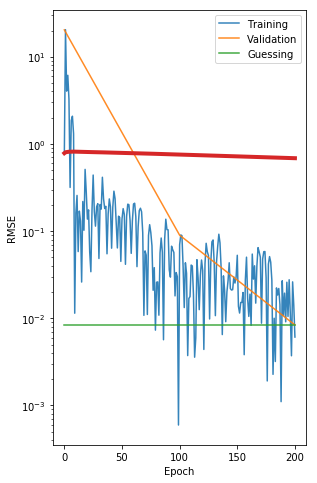

201 0.00172237
202 0.0153903
203 0.00197805
204 0.00128597
205 0.00147077
206 0.0122182
207 0.0163338
208 0.000829689
209 0.0364271
210 0.0277166
211 0.0324233
212 0.00117043
213 0.0163393
214 0.0291411
215 0.0337988
216 0.0187298
217 0.000630052
218 0.0210775
219 0.0200108
220 0.0316479
221 0.0373446
222 0.0263239
223 0.00795971
224 0.021077
225 0.038037
226 0.03616
227 0.0289359
228 0.000405935
229 0.016407
230 0.0123838
231 0.0110477
232 0.0125202
233 0.000334001
234 0.0242879
235 0.0308675
236 0.0320745
237 0.0041084
238 0.0342235
239 0.0127722
240 0.0322201
241 0.0192746
242 0.00622627
243 0.00841467
244 0.0137011
245 0.0162406
246 0.0329963
247 0.0439424
248 0.0443655
249 0.0241906
250 0.00363683
251 0.00887102
252 0.00166058
253 0.0154594
254 0.0248662
255 0.00505995
256 0.0154189
257 0.018693
258 0.00233007
259 0.0191738
260 0.0154698
261 0.00524607
262 0.0204635
263 0.0324157
264 0.0292405
265 0.0128872
266 0.0291744
267 0.0205594
268 0.0296817
269 0.0321353
270 0.00684925
271

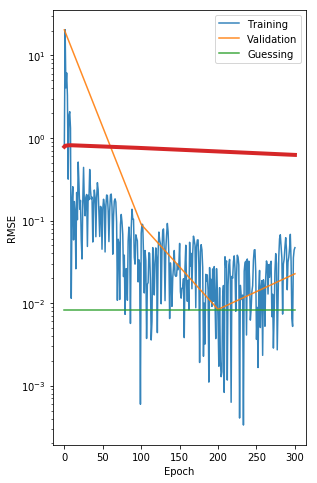

301 0.0189974
302 0.00258748
303 0.0399312
304 0.0554753
305 0.0726847
306 0.0425634
307 0.0381672
308 0.00684835
309 0.0217517
310 0.0434995
311 0.0709656
312 0.0537376
313 0.0336607
314 0.000146082
315 0.0216481
316 0.0564969
317 0.0563941
318 0.050358
319 0.0413788
320 0.0092826
321 0.0146994
322 0.0478789
323 0.05068
324 0.0267973
325 0.000859788
326 0.00441383
327 0.0439839
328 0.0550926
329 0.0779675
330 0.0570665
331 0.0414686
332 0.0226382
333 0.0218703
334 0.064321
335 0.0274616
336 0.0344977
337 0.0242448
338 0.00725573
339 0.0247893
340 0.0297938
341 0.0068977
342 0.0104008
343 0.0208545
344 0.023329
345 0.0056103
346 0.0108642
347 0.00292057
348 0.0338179
349 0.0460157
350 0.0481516
351 0.0320381
352 0.00644092
353 0.0264
354 0.0348978
355 0.038725
356 0.0357089
357 0.00885923
358 0.00471168
359 0.0279573
360 0.0249646
361 0.0176558
362 0.0034652
363 0.00943699
364 0.0179624
365 0.0291414
366 0.00347895
367 0.0116249
368 0.0187184
369 0.0299509
370 0.0440119
371 0.016939
37

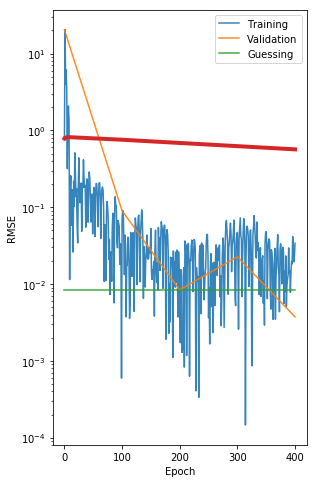

401 0.00440809
402 0.0220969
403 0.0467441
404 0.0192164
405 0.00110109
406 0.021574


KeyboardInterrupt: 

In [4]:
# simple parameters:
disp_period = 100
training_iters = 40000
lr = 0.1 
lr_decay= 0.99

# Launch the graph
step = 1 
history = {'train_loss': [], 's_tloss': [], 'val_inds': [], 'val_loss':[], 'corr':[]}
smooth_val = 0.999

for step in range(training_iters):
    if step % 300 is 0:
        lr *= lr_decay
    imu_batch,img_batch,y_batch = utilities.sample_seqbatch(BATCH_SIZE,R_HISTORY, x_train, y_train, img_train)
    f = sess.run(feats, feed_dict={conv_model.image:img_batch})
    feature_input = f[-2].reshape(BATCH_SIZE*R_HISTORY,-1)
    o,loss = sess.run([model.optimizer,model.loss], feed_dict={model.labels:y_batch, model.imgdata:feature_input, model.data:imu_batch, model.lr:[0.01]})
    print(step,loss)

    history["train_loss"].append(loss)
    if(step is 0):
        history["s_tloss"].append(loss)
    else:
        history["s_tloss"].append(smooth_val*history["s_tloss"][-1] + (1-smooth_val)*loss)

    if step % disp_period is 0:
        # Calculate val accuracy:
        imu_batch,img_batch,y_batch = utilities.sample_seqbatch(BATCH_SIZE,R_HISTORY, x_val, y_val, img_train)
        f = sess.run(feats, feed_dict={conv_model.image:img_batch})
        feature_input = f[-2].reshape(BATCH_SIZE*R_HISTORY,-1)
        loss_v = sess.run(model.loss, feed_dict={model.labels:y_batch, model.imgdata:feature_input, model.data:imu_batch})
        history["val_loss"].append(loss_v)
        history["val_inds"].append(step)

        print('Step: ', step, ' Train: ', history["s_tloss"][-1], ' Val: ', history["val_loss"][-1], 'LR: ', lr)

        rmse_zero = utilities.calc_rmse(np.zeros_like(y_data),y_data)

        saver.save(sess, './recursive_ckpts/recursive_model', global_step = step)
        # Only run prediction if it seems reasonable:
        if(False and history["s_tloss"][-1] < 1.5*rmse_zero and step %10*disp_period==0):
            y_pred = np.zeros_like(y_data)
            state = np.zeros(N_HIDDEN)
            print('Loss is ',history["s_tloss"][-1] ,'. Running Prediction: ')
            m_state = np.zeros(y_data.shape[0])
            y_pred = np.zeros(y_data.shape[0])
            for k in range( y_data.shape[0]-BATCH_SIZE*R_HISTORY):
                if k % 1000 is 0:
                    print('k = ', k)
                batch_x, batch_y = utilities.sample_seqbatch(R_HISTORY, BATCH_SIZE,x_data,y_data, k)
                if batch_x.shape[0] != R_HISTORY*BATCH_SIZE or batch_y.shape[0] != R_HISTORY*BATCH_SIZE:
                    print('Error in batch_x shape at ', k, ' shapes: ',batch_x.shape, batch_y.shape)
                    continue
                pred,state = sess.run([model.prediction,model.state], feed_dict={model.state:state,model.data: batch_x, model.labels: batch_y})
                m_state[k] = np.max(state)
                if k < y_pred.shape[0]:
                    y_pred[k] = pred[-1]
                else:
                    print('Error assigning to element ', k)
            c = utilities.plot_data(0,y_data.shape[0], y_pred, y_data, x_train.shape[0])
            history["corr"].append(c)

            rmse_pred = utilities.calc_rmse(y_pred, y_data)
            print('RMSE: ', rmse_pred)
            print('Ratio to zeros: ', rmse_pred/rmse_zero)

        plt.subplot(1,2,1)
        plt.semilogy(history["train_loss"],alpha=0.9)
        plt.semilogy(history["val_inds"], history["val_loss"],alpha=0.9)
        plt.semilogy([0,step], [rmse_zero,rmse_zero],alpha=0.9)
        plt.legend(['Training','Validation','Guessing'])
        plt.semilogy(history["s_tloss"],linewidth=4)
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
#        plt.subplot(1,2,2)

#        plt.plot(history["val_inds"], history["corr"])
#        plt.ylabel('Correlation')
#        plt.xlabel('epoch') 
        
        
        plt.show()

    # Compute sequence prediction:
print('Done.')


INFO:tensorflow:Restoring parameters from ./recursive_ckpts/recursive_model-200


INFO:tensorflow:Restoring parameters from ./recursive_ckpts/recursive_model-200


k =  0
k =  10
k =  20
k =  30
k =  40
k =  50
k =  60
k =  70
k =  80
k =  90
k =  100
k =  110
k =  120
k =  130
k =  140
k =  150
k =  160
k =  170
k =  180
k =  190
k =  200
k =  210
k =  220
k =  230
k =  240
k =  250
k =  260
k =  270
k =  280
k =  290
k =  300
k =  310
k =  320
k =  330
k =  340
k =  350
k =  360
k =  370
k =  380
k =  390
k =  400
k =  410
k =  420
k =  430
k =  440
k =  450
k =  460
k =  470
k =  480
k =  490
k =  500
k =  510
k =  520
k =  530
k =  540
k =  550
k =  560
k =  570
k =  580
k =  590
k =  600
k =  610
k =  620
k =  630
k =  640
k =  650
k =  660
k =  670
k =  680
k =  690
k =  700
k =  710
k =  720
k =  730
k =  740
k =  750
k =  760
k =  770
k =  780
k =  790
k =  800
k =  810
k =  820
k =  830
k =  840
k =  850
k =  860
k =  870
k =  880
k =  890
k =  900
k =  910
k =  920
k =  930
k =  940
k =  950
k =  960
k =  970
k =  980
k =  990
plotting from  0  to  1000
High correlation (near 1) means we are predicting well.
Correlation between error an

/home/stimj09/teach-me-to-tango/utilities.py:205: RuntimeWarning: invalid value encountered in double_scalars
  c12 = (np.correlate(actual[ns:ne]-m1,pred[ns:ne]-m2))[0]/(c1*c2)
/home/stimj09/teach-me-to-tango/utilities.py:206: RuntimeWarning: invalid value encountered in absolute
  print('Correlation between error and signal:', (np.abs(c12)))


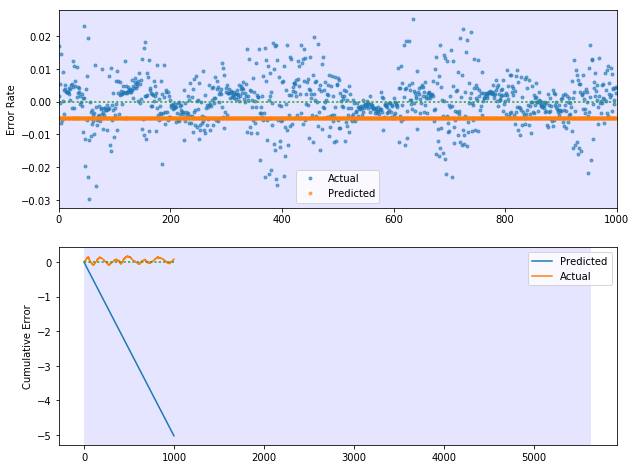

nan
RMSE:  0.00850968655745


/home/stimj09/teach-me-to-tango/utilities.py:235: RuntimeWarning: invalid value encountered in absolute
  return np.abs(c12)


NameError: name 'rmse_zero' is not defined

In [8]:
saver.restore(sess, './recursive_ckpts/recursive_model-200')

# Now predict:
y_pred = np.zeros_like(y_data)
state = np.zeros(N_HIDDEN)
m_state = np.zeros(y_data.shape[0])
y_pred = np.zeros(y_data.shape[0])
for k in range( 1000 ):
    if k % 10 is 0:
        print('k = ', k)
    imu_batch,img_batch,y_batch = utilities.sample_seqbatch(BATCH_SIZE,R_HISTORY, x_val, y_val, img_train,k)
    f = sess.run(feats, feed_dict={conv_model.image:img_batch})
    feature_input = f[-2].reshape(BATCH_SIZE*R_HISTORY,-1)
    pred,state = sess.run([model.prediction,model.state], feed_dict={model.state:state,model.labels:y_batch, model.imgdata:feature_input, model.data:imu_batch})
    m_state[k] = np.max(state)
    if k < y_pred.shape[0]:
        y_pred[k] = pred[-1]
    else:
        print('Error assigning to element ', k)
c = utilities.plot_data(0,1000, y_pred, y_data, x_train.shape[0])
print(c)
rmse_pred = utilities.calc_rmse(y_pred, y_data)
print('RMSE: ', rmse_pred)
print('Ratio to zeros: ', rmse_pred/rmse_zero)

 